In [2]:
import numpy as np
import ast
import importlib.machinery
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim.lr_scheduler import LambdaLR
import os
import copy
import pandas as pd
from matplotlib import image
from PIL import Image
from network_upsampling import Snow_loss, Snow_dataset, Snow_model as Snow_model_up

sys.path.append('./pytorch-CycleGAN-and-pix2pix')
from models.networks import define_G
# os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [ ]:
import math

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


import numpy as np
from PIL import Image 
from scipy.signal import convolve2d
 
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h
 
def filter2(x, kernel, mode='same'):
    return convolve2d(x, np.rot90(kernel, 2), mode=mode)
 
def compute_ssim(im1, im2, k1=0.01, k2=0.03, win_size=11, L=255):
 
    if not im1.shape == im2.shape:
        raise ValueError("Input Imagees must have the same dimensions")
    if len(im1.shape) > 2:
        raise ValueError("Please input the images with 1 channel")
 
    M, N = im1.shape
    C1 = (k1*L)**2
    C2 = (k2*L)**2
    window = matlab_style_gauss2D(shape=(win_size,win_size), sigma=1.5)
    window = window/np.sum(np.sum(window))
 
    if im1.dtype == np.uint8:
        im1 = np.double(im1)
    if im2.dtype == np.uint8:
        im2 = np.double(im2)
 
    mu1 = filter2(im1, window, 'valid')
    mu2 = filter2(im2, window, 'valid')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = filter2(im1*im1, window, 'valid') - mu1_sq
    sigma2_sq = filter2(im2*im2, window, 'valid') - mu2_sq
    sigmal2 = filter2(im1*im2, window, 'valid') - mu1_mu2
 
    ssim_map = ((2*mu1_mu2+C1) * (2*sigmal2+C2)) / ((mu1_sq+mu2_sq+C1) * (sigma1_sq+sigma2_sq+C2))
 
    return np.mean(np.mean(ssim_map))


def tensor2im(input_image, imtype=np.uint8, desnow=False):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        result = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
        if desnow:
            result = (np.transpose(image_numpy, (1, 2, 0))) * 255.0
    else:  # if it is a numpy array, do nothing
        result = input_image
    return result.astype(imtype)
n = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


In [354]:

model = Snow_model_up(initial_size=4).cpu()
cp = torch.load('./downsampling_desnowNet_xavier_256/best_checkpoint_-0.3542.pt')
model.load_state_dict(cp['model_state_dict'])
model.eval()

G = define_G(3, 3, 64, 'resnet_9blocks', norm='instance', aspp=True)

GU = define_G(3, 3, 64, 'unet_256', norm='instance', aspp=True)

cp = torch.load('./pytorch-CycleGAN-and-pix2pix/checkpoints/snow_cyclegan_aspp/latest_net_G_A.pth')
G.load_state_dict(cp)
G.eval()

cp = torch.load('./pytorch-CycleGAN-and-pix2pix/checkpoints/snow_cycle_gan_unet/latest_net_G_A.pth')
GU.load_state_dict(cp)
GU.eval()
n = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


In [ ]:
# /test/Snow100K-S/
# city_read_12603
# winter_japan_10740
# city_read_19791
# crossing_04544


# all
# winter_park_12839


In [362]:
z = Image.open(f"./all/mask/winter_park_12839.jpg")
y = Image.open(f"./all/gt/winter_park_12839.jpg")
x = Image.open(f"./all/synthetic/winter_park_12839.jpg")
z = transforms.Grayscale()(z)
osize = [256, 256]
re = transforms.Resize(osize, transforms.InterpolationMode.BICUBIC)
x = re(x)
y = re(y)
z = re(z)
z = transforms.ToTensor()(z)
y = transforms.ToTensor()(y)
x = transforms.ToTensor()(x)
with torch.no_grad():
    y_hat, y_prime, z_hat = model(x.unsqueeze(0), train=False)
    


In [374]:
nx = n(x)
with torch.no_grad():
    result_GU = GU(nx.unsqueeze(0))
    result_G = G(nx.unsqueeze(0))


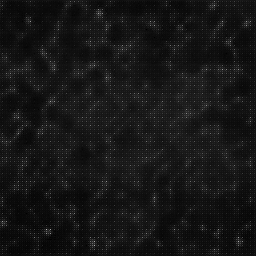

In [375]:
transforms.ToPILImage()(z_hat.squeeze(0))


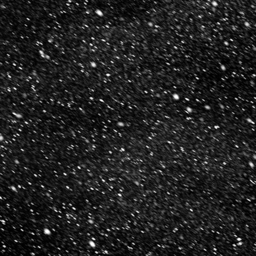

In [376]:
transforms.ToPILImage()(z)


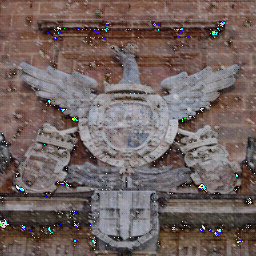

In [377]:
transforms.ToPILImage()(y_prime.squeeze(0))


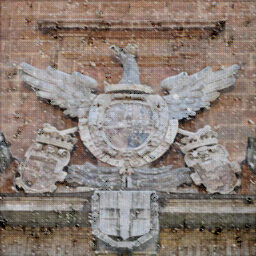

In [378]:
transforms.ToPILImage()(y_hat.squeeze(0))


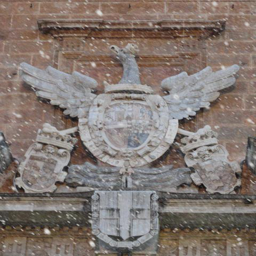

In [379]:
transforms.ToPILImage()(x)


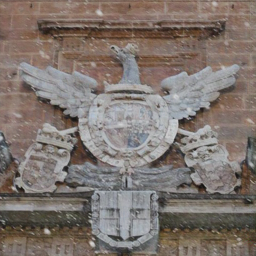

In [380]:
transforms.ToPILImage()(tensor2im(result_GU))


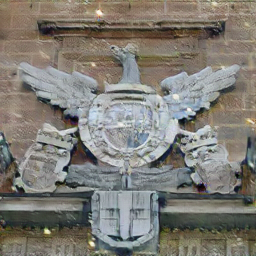

In [381]:
transforms.ToPILImage()(tensor2im(result_G))


In [382]:
print(calculate_psnr(255*y.numpy(), tensor2im(result_GU).transpose(2, 0, 1)))


25.461342413269634


In [383]:
print(calculate_psnr(255*y.numpy(), tensor2im(result_G).transpose(2, 0, 1)))


22.506103758700654


In [384]:
print(calculate_psnr(255*y.numpy(), 255 * y_hat.numpy()))


20.42436431561967
